In [ ]:
!pip install -q torch_harmonics neuraloperator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from neuralop.models import FNO  # Import FNO from NeuralOperator
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt

In [ ]:
import accelerate

In [ ]:
accelerator = accelerate.Accelerator()
device = accelerator.device

In [ ]:
def generate_potential_data(num_samples, grid_size, num_eigenvalues, device, dtype=torch.float32):
    # Create the grid and potential
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    V = 0.5 * (X**2 + Y**2)  # Harmonic potential
    V_flat = V.flatten()  # Flatten once

    # Generate finite difference matrices for the potential grid
    dx = x[1] - x[0]
    D2_1D = sp.diags([1, -2, 1], [-1, 0, 1], shape=(grid_size, grid_size)) / dx**2
    I = sp.identity(grid_size)
    D2_2D = sp.kron(D2_1D, I) + sp.kron(I, D2_1D)

    # Precompute Hamiltonian
    H = -0.5 * D2_2D

    # Compute eigenvalues for all samples
    eigenvalues = []
    potentials = [V] * num_samples  # Create a list of the same potential for all samples

    for _ in range(num_samples):
        # Add the potential to the Hamiltonian
        H_with_potential = H + sp.diags(V_flat, 0)

        # Compute eigenvalues
        E, _ = spla.eigsh(H_with_potential, k=num_eigenvalues, which='SM')
        eigenvalues.append(np.sort(E))

    return torch.tensor(np.array(potentials), dtype=dtype).to(device), torch.tensor(np.array(eigenvalues), dtype=dtype).to(device)

In [ ]:
# Hyperparameters
num_samples = 500
grid_size = 30
num_eigenvalues = 25
learning_rate = 1e-3
num_epochs = 100

# Initialize the model
fno_model = FNO(
    n_modes=(10, 10),
    hidden_channels=128,
    in_channels=1,
    out_channels=num_eigenvalues,
    lifting_channels=64,
    projection_channels=64,
    n_layers=64
)


# Create optimizer and loss function
optimizer = optim.Adam(fno_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [ ]:
fno_model, optimizer, loss_fn, generate_potential_data = accelerator.prepare(fno_model, optimizer, loss_fn, generate_potential_data)

In [ ]:
train_potentials, train_eigen_vals = generate_potential_data(num_samples, grid_size, num_eigenvalues, device=device)
val_potentials, val_eigen_vals = generate_potential_data(10, grid_size, num_eigenvalues, device=device)

In [ ]:
import time

In [ ]:
start = time.time()
# Training Loop
losses = []
for epoch in range(num_epochs):
    # Set the model to training mode
    fno_model.train()

    predicted_eigen_vals = fno_model(train_potentials.unsqueeze(1))

    # Extract the eigenvalues by averaging over the spatial dimensions
    predicted_eigen_vals = predicted_eigen_vals.mean(dim=[2, 3])  # Shape: [500, 25]

    # Compute the loss
    # train_eigen_vals = torch.tensor(train_eigen_vals, dtype=torch.float32).to(device)
    loss = loss_fn(predicted_eigen_vals, train_eigen_vals)
    # compute relative error
    loss = loss -  / torch.mean(train_eigen_vals)
    losses.append(loss)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update model parameters

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

end = time.time()
print(f'Time taken: {end - start}')

Epoch [10/100], Loss: 20.4333
Epoch [20/100], Loss: 8.4429
Epoch [30/100], Loss: 0.4175
Epoch [40/100], Loss: 0.1810
Epoch [50/100], Loss: 0.0795
Epoch [60/100], Loss: 0.0221
Epoch [70/100], Loss: 0.0097
Epoch [80/100], Loss: 0.0020
Epoch [90/100], Loss: 0.0013
Epoch [100/100], Loss: 0.0002
Time taken: 95.31178212165833


Validation Loss: 0.00041
Mean Absolute Error: 0.01631


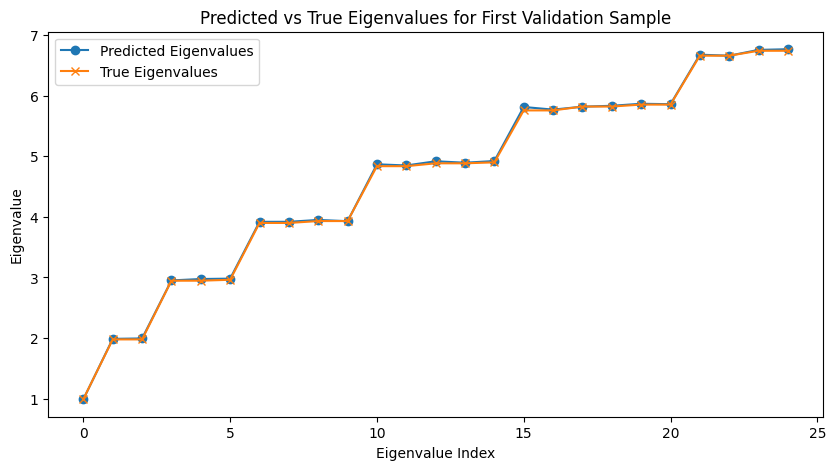

In [ ]:
# Validation Phase
fno_model.eval()  # Set the model to evaluation mode

# Forward pass: compute predicted eigenvalues for validation data
with torch.no_grad():  # Disable gradient calculation
    predicted_val_eigen_vals = fno_model(val_potentials.unsqueeze(1))
    predicted_val_eigen_vals = predicted_val_eigen_vals.mean(dim=[2, 3])  # Shape: [10, 25]

# Compute validation loss
# val_eigen_vals = torch.tensor(val_eigen_vals, dtype=torch.float32).to(device)
val_loss = loss_fn(predicted_val_eigen_vals, val_eigen_vals)

# Print validation loss
print(f'Validation Loss: {val_loss.item():.5f}')

# Optional: Calculate additional metrics
# For example, Mean Absolute Error (MAE)
mae = torch.mean(torch.abs(predicted_val_eigen_vals - val_eigen_vals))
print(f'Mean Absolute Error: {mae.item():.5f}')



# Plotting the first predicted vs actual eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(predicted_val_eigen_vals[0].cpu(), label='Predicted Eigenvalues', marker='o')
plt.plot(val_eigen_vals[0].cpu(), label='True Eigenvalues', marker='x')
plt.title('Predicted vs True Eigenvalues for First Validation Sample')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.savefig('validation_plot.png')
plt.show()

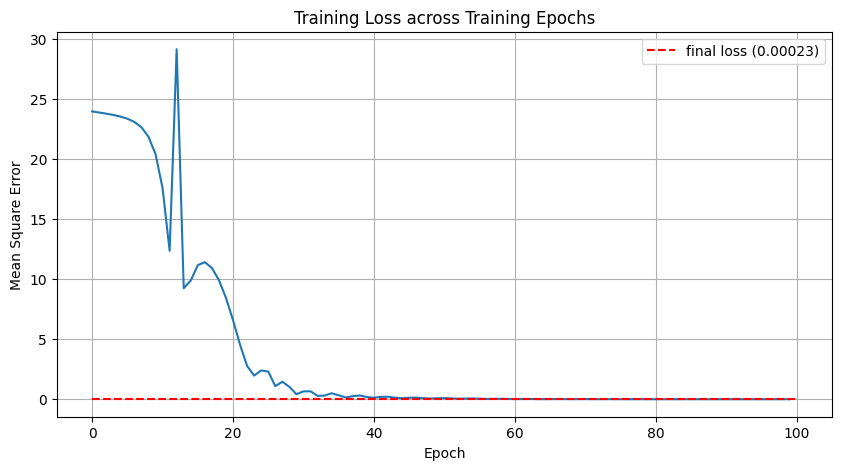

In [ ]:
plt.figure(figsize=(10, 5))

plt_losses = [i.item() for i in losses]
plt.plot(plt_losses)
plt.hlines(plt_losses[-1], 0, len(plt_losses), linestyles='dashed', color='r', label=f'final loss ({round(plt_losses[-1], 5)})')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.title('Training Loss across Training Epochs')
plt.legend()
plt.savefig('training_loss.png')
plt.show()